# CIFAR-10 playground

This is a Jupyter notebook dedicated to testing various ML algorithms on CIFAR-10 dataset. It mostly serves as a practical exercise for myself to learn how to use numpy/scipy/tensorflow/keras.

### Prerequisites: 
* Jupyter Lab, installed into a conda environment (I used the default base environment). I am using a clean install of miniconda from official website (downloaded on 03-08-2018), following by installing Jupyter Lab via ` conda install -c conda-forge jupyterlab `. 
* Packages: numpy, scipy, pandas, scikit-learn, tensorflow, keras, all installed in a separate conda environment.
<details>
    <summary>Example of installation on older hardware (click to unroll):</summary>
    
    * My laptop is quite old (it was a flagship model in 2012). It has an AMD GPU and its old Intel CPU (Pentium 2020M) lacks AVX instructions that Tensorflow commonly uses. Because of this, normal installation of Tensorflow via regular repositories won't work. Instead, we need to install a community wheel of CPU Tensorflow compiled for this system spec for 64-bit linux (I am using Ubuntu 18.04):
        * Download one of the two wheels (I am currently using the second one):
            * Without AVX and SSE instructions: https://github.com/davidenunes/tensorflow-wheels/releases/download/r1.13.1.cp36.cpu/tensorflow-1.13.1-cp36-cp36m-linux_x86_64.whl 
            * Without AVX, **with** SSE instrucions: https://github.com/mdsimmo/tensorflow-community-wheels/releases/download/1.13.1_cpu_py3_6_amd64/tf_nightly-1.13.1-cp36-cp36m-linux_x86_64.whl
        * Create a separate conda environment for the notebook and integrate it into jupyter:
        * ` (base)$ conda create -n py36_for_tensorflow python=3.6 `    
        * ` (base)$ conda activate py36_for_tensorflow `
        * ` (py36_for_tensorflow)$ conda install ipykernel `
        * ` (py36_for_tensorflow)$ python -m ipykernel install --user --name dlwp --display-name="Python 3.6 for Deep Learning" `
        * ` (py36_for_tensorflow)$ pip install /path/to/downloaded/wheel.whl `
        * ` (py36_for_tensorflow)$ pip install scipy matplotlib pandas keras `
        * ` (py36_for_tensorflow)$ deactivate `
        * ` (base)$ jupyter lab `
    * In Jupyter Lab, stop the kernel. Set the notebook's kernel to Python 3.6 for Deep Learning. Restart the kernel.
    * Make sure that the following cell correctly gives the python 3.6 version.
</details>

In [1]:
import sys
print(sys.version)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


### 1. Importing data and looking at its structure


Import the necessary libraries. If everything was installed correctly, evaluating the next cell once should yield a couple warnings about older version of Tensorflow, and on the second evaluation should yield something along the lines of `c == [6]` and nothing else.

In [3]:
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sklearn
# Tell tensorflow not to be super verbose when doing stuff
tf.logging.set_verbosity(tf.logging.WARN)

a = 2
b = 3
c = tf.multiply(a, b)
with tf.Session() as sess:
    print('c == '+str(sess.run([c])))

c == [6]


Make a function for importing data from the compressed binary format in which the original dataset is provided.

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

Decompress the dataset. The details on its structure are provided at https://www.cs.toronto.edu/~kriz/cifar.html

In brief, each example's features (32x32 image) are stored as an unrolled array of 3072 (32x32x3) integers (uint8, 0-255, ordered as rgb). Each image has a corresponding "label" - the category to which the object belongs (0-9).

In [4]:
!tar xzvf ./input/cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Load metadata and data objects. Concatenate data objects together. 

In [36]:
batches_meta = unpickle('./cifar-10-batches-py/batches.meta')
print(batches_meta)
label_names = batches_meta[b'label_names']
print(label_names)
print('Loading data...')
data_batch_1 = unpickle('./cifar-10-batches-py/data_batch_1')
data_batch_2 = unpickle('./cifar-10-batches-py/data_batch_2')
data_batch_3 = unpickle('./cifar-10-batches-py/data_batch_3')
data_batch_4 = unpickle('./cifar-10-batches-py/data_batch_4')
data_batch_5 = unpickle('./cifar-10-batches-py/data_batch_5')
X_raw = np.concatenate( ( data_batch_1[b'data'], 
                          data_batch_2[b'data'], 
                          data_batch_3[b'data'], 
                          data_batch_4[b'data'], 
                          data_batch_5[b'data']  ),
                        axis=0
)
Y_raw = np.concatenate( ( data_batch_1[b'labels'], 
                          data_batch_2[b'labels'], 
                          data_batch_3[b'labels'], 
                          data_batch_4[b'labels'], 
                          data_batch_5[b'labels']  ),
                        axis=0
)
N_DIMENSIONS = batches_meta[b'num_vis']
print('Data loaded.')

{b'num_cases_per_batch': 10000, b'label_names': [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck'], b'num_vis': 3072}
[b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Loading data...
Data loaded.


Make a small subset of data to show some examples later.

In [37]:
example_set_size = 20000
X_example_set = X_raw[0:example_set_size]
Y_example_set = Y_raw[0:example_set_size]

In case of a slow machine, actually use this subset as "raw" data.

In [38]:
X_raw = X_example_set
Y_raw = Y_example_set

Plot some examples:

In [8]:
def prep_for_plotting(data_array):
    return data_array.reshape((3,32,32)).transpose((1,2,0))

def show_examples_of_data(X_show, Y_show, **options):
    show_probabilities = options.get("show_probabilities")
    probabilities = options.get("probabilities")
    m, n = 8, 3
    fig, ax = plt.subplots(n, m, figsize=(m*2,n*2))

    for i in range(0,n):
        for j in range(0,m):
            k = i*m+j;
            example = X_show[k]
            example_label = Y_show[k]
            example_label_name = label_names[example_label].decode('utf-8')
            
            if show_probabilities:
                probability_label = str(int(probabilities[k]*100))
                example_full_label_name = str(k)+': '+probability_label+'% '+example_label_name+' ('+str(example_label)+')'
            else:
                example_full_label_name = str(k)+': '+example_label_name+' ('+str(example_label)+')'

            example_prepped_for_plotting = prep_for_plotting(example);
            ax[i,j].imshow(example_prepped_for_plotting)
            ax[i,j].text(1, 3, example_full_label_name, bbox={'facecolor': 'white', 'pad': 2})
            ax[i,j].axis('off')
    plt.show()

In [ ]:
show_examples_of_data(X_raw, Y_raw)

Let's look at the distribution of some of the features. It's pretty clear that they seem to follow a truncated normal distribution, with a bunch of outliers on the upper range. As we have prior information on all features being isotropic, we can also look at the overall histogram for _all_ features at the same time:

In [ ]:
step = 500
plt.figure(figsize=(12,3))
plt.subplot(1, 2, 1)
_ = plt.hist(X_example_set[:,0:N_DIMENSIONS:step], bins=16, histtype='bar')
plt.subplot(1, 2, 2)
_ = plt.hist(np.ravel(X_example_set), bins=64, histtype='bar')

As the dataset is large, normality tests are not very useful. Let's visually inspect some Q-Q plots:

In [ ]:
from scipy import stats
step = 500
plt.figure(figsize=(N_DIMENSIONS//step*2, 2))
for i in range(1,N_DIMENSIONS//step):
    plt.subplot(1, N_DIMENSIONS//step, i)
    _ = stats.probplot(X_example_set[:,step*i], plot=plt)


### 2. Pre-processing the data

As the distributions are close enough to normal, we can standardize the data without any additional preprocessing. Standardization means that the data would have mean = 0 and variance = 1 for each feature.

In [39]:
from sklearn import preprocessing
print('Initial data:')
print(X_example_set)

scaler = preprocessing.StandardScaler()
scaler.fit(X_example_set)

print('\nStandardized data with 0 mean and 1 variance on each column:')
X_example_set_standardized = scaler.transform(X_example_set)
print(X_example_set_standardized)

print('Means for features: '+str(scaler.mean_))
print('St.d. for features: '+str(np.sqrt(scaler.var_)))

Initial data:
[[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]
 [255 253 253 ...  83  83  84]
 ...
 [127 139 155 ... 197 192 191]
 [190 200 208 ... 163 182 192]
 [177 174 182 ... 119 127 136]]

Standardized data with 0 mean and 1 variance on each column:
[[-0.98076185 -1.20456063 -1.12605757 ...  0.39530394 -0.46221326
  -0.64530112]
 [ 0.30944175 -0.06223605 -0.36559696 ...  0.37997261  0.42111999
   0.4374542 ]
 [ 1.6811319   1.68565819  1.68073338 ... -0.47858223 -0.47744315
  -0.4648419 ]
 ...
 [-0.05724769  0.11668226  0.32573085 ...  1.26919012  1.18261418
   1.14425281]
 [ 0.79836101  0.95622201  1.05853834 ...  0.74792468  1.03031534
   1.15929108]
 [ 0.62180684  0.5983854   0.69904788 ...  0.07334588  0.19267174
   0.31714806]]
Means for features: [131.21525 130.522   131.44165 ... 114.21595 114.3491  114.9106 ]
St.d. for features: [73.63178945 72.65885848 72.32458846 ... 65.22588609 65.66038325
 66.49701804]


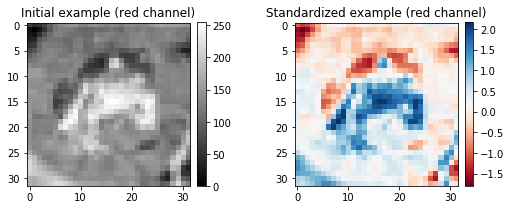

In [10]:
def prep_for_plotting_grayscale_r(data_array):
    return data_array.reshape((3,32,32))[0]

fig, ax = plt.subplots(figsize=(8,16), ncols=2)
fig.subplots_adjust(wspace=0.5)

ax0 = ax[0].imshow(prep_for_plotting_grayscale_r(X_example_set[0]), cmap='gray')
fig.colorbar(ax0, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].title.set_text('Initial example (red channel)')
ax1 = ax[1].imshow(prep_for_plotting_grayscale_r(X_example_set_standardized[0]), cmap='RdBu')
fig.colorbar(ax1, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].title.set_text('Standardized example (red channel)')

plt.show()

Having confirmed that the standardization works, we can now use it on the entire dataset.

In [40]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_raw)

X = scaler.transform(X_raw)

Let's try using a perceptron first. For this (and any other neural network method) each of the labels of the training data needs to be reformatted into a "one-hot" vector format: a zero vector with a one in the category corresponding to the label. Both scikit-learn and keras provide utilities for this. I use the function from keras because it's shorter (albeit limited in functionality).

In [41]:
Y = keras.utils.to_categorical(Y_raw, num_classes=10)
print(Y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Split the data into training, test, and cross-reference sets.

In [42]:
from sklearn.model_selection import train_test_split
# Use this much data for cross-validation purposes during model comparison
crossval_proportion = 0.2
# Use this much data for test purposes during training
test_proportion = 0.2
test_proportion_secondsplit = (test_proportion/(1-crossval_proportion))

random_seed = 123
X_traintest, X_cv, Y_traintest, Y_cv = train_test_split(X, Y, test_size=crossval_proportion, random_state=random_seed)
X_train, X_test, Y_train, Y_test = train_test_split(X_traintest, Y_traintest, test_size=test_proportion_secondsplit, random_state=random_seed)

print("X_train matrix shape: "+str(X_train.shape)+"; Y_train matrix shape: "+str(Y_train.shape))
print("X_test  matrix shape: "+str(X_test.shape )+"; Y_test  matrix shape: "+str(Y_test.shape ))
print("X_cv    matrix shape: "+str(X_cv.shape   )+"; Y_cv    matrix shape: "+str(Y_cv.shape   ))

X_train matrix shape: (12000, 3072); Y_train matrix shape: (12000, 10)
X_test  matrix shape: (4000, 3072); Y_test  matrix shape: (4000, 10)
X_cv    matrix shape: (4000, 3072); Y_cv    matrix shape: (4000, 10)


### 3. Using a perceptron

Make the neural network using keras.

In [99]:
from keras.models import Sequential
from keras.layers import Dense

def make_perceptron_model():
    model = Sequential()
    # First layer: 3072 inputs fed into smooth rectifier units
    model.add(Dense(units=512, activation='softplus', input_dim=N_DIMENSIONS))
    model.add(Dense(units=128, activation='softplus', input_dim=N_DIMENSIONS))
    # Last layer (output): 10 outputs, softmax: yields a bunch of values which sum up to 1; 
    # corresponds to "probabilities" in each category
    model.add(Dense(units=10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

model = make_perceptron_model()

Train the model.

In [23]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accurs = []
        self.val_accurs = []
        self.losses = []
        self.val_losses = []
    # def on_batch_end(self, batch, logs={}):
        # self.accurs.append(logs.get('acc'))
        # self.losses.append(logs.get('loss'))
    def on_epoch_end(self, epoch, logs={}):
        self.val_accurs.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))        
        self.accurs.append(logs.get('acc'))
        self.losses.append(logs.get('loss'))        

history = LossHistory()        
h = model.fit(X_train, Y_train, epochs=20, batch_size=128, callbacks=[history], validation_data=(X_cv,Y_cv))

Train on 6000 samples, validate on 2000 samples
Epoch 1/20
6000/6000 [==============================] - 6s 1ms/step - loss: 2.1363 - acc: 0.2280 - val_loss: 1.9850 - val_acc: 0.2805
Epoch 2/20
6000/6000 [==============================] - 6s 966us/step - loss: 1.8914 - acc: 0.3337 - val_loss: 1.8934 - val_acc: 0.3260
Epoch 3/20
6000/6000 [==============================] - 6s 966us/step - loss: 1.8006 - acc: 0.3682 - val_loss: 1.8370 - val_acc: 0.3410
Epoch 4/20
6000/6000 [==============================] - 6s 963us/step - loss: 1.7325 - acc: 0.3888 - val_loss: 1.7874 - val_acc: 0.3770
Epoch 5/20
6000/6000 [==============================] - 6s 965us/step - loss: 1.6888 - acc: 0.4102 - val_loss: 1.7779 - val_acc: 0.3660
Epoch 6/20
6000/6000 [==============================] - 6s 968us/step - loss: 1.6407 - acc: 0.4250 - val_loss: 1.7398 - val_acc: 0.3890
Epoch 7/20
6000/6000 [==============================] - 6s 1ms/step - loss: 1.6095 - acc: 0.4370 - val_loss: 1.7188 - val_acc: 0.3905
Epoc

Evaluate the model on the test set.

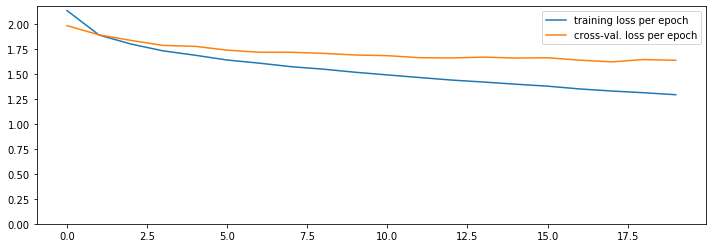

2000/2000 [==============================] - 1s 412us/step
Loss on test set: ~1.67
Accuracy on test set: ~43%


In [36]:
accurs = history.accurs
val_accurs = history.val_accurs
losses = history.losses 
val_losses = history.val_losses 
epoch_numbers = list(range(0,history.params['epochs']))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

We can see that the cross-validation loss decays very slowly on each epoch and eventually plateaus out. This implies that the model isn't learning to generalize data, but instead goes into overfitting.

Show some examples of model's predictions for the test data.

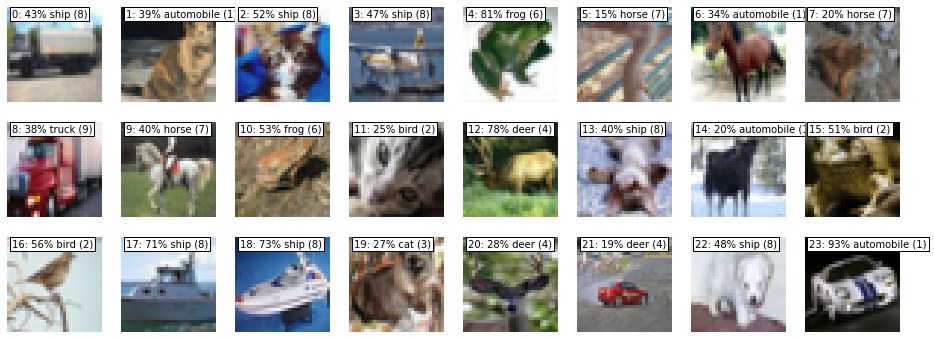

In [38]:
Y_predicted = model.predict(X_test, batch_size=128)

Y_predicted_probability = np.max(Y_predicted, axis=1)
Y_predicted_category = np.argmax(Y_predicted, axis=1)

X_show = scaler.inverse_transform(X_test).astype(int)
show_examples_of_data(X_show, Y_predicted_category, show_probabilities=True, probabilities=Y_predicted_probability)

Let's try following the dependency of training error and cross-validation depending on the input size.

In [100]:
number_subset_cases = 10
subset_sizes = list(np.logspace(1,np.log10(len(X_train)),num=number_subset_cases).astype(int))
print('Using following subset sizes: '+str(subset_sizes))
losses_for_subsets = []
val_losses_for_subsets = []

for i in range(0,number_subset_cases):    
    print('Training the model on subset size of '+str(subset_sizes[i])+':')
    model = make_perceptron_model()
    history = LossHistory()        
    X_train_subset = X_train[0:(subset_sizes[i]-1)]
    Y_train_subset = Y_train[0:(subset_sizes[i]-1)]
    h = model.fit(X_train_subset, Y_train_subset, 
                  epochs=20, batch_size=128, 
                  callbacks=[history], validation_data=(X_cv,Y_cv), 
                  verbose=0)
    losses_for_subsets     += [history.losses[-1]]
    val_losses_for_subsets += [history.val_losses[-1]]
    print('Final training loss: '+str(history.losses[-1]))
    print('Final crossval loss: '+str(history.val_losses[-1]))
print('Finished.')

Using following subset sizes: [10, 20, 41, 84, 171, 349, 711, 1448, 2947, 6000]
Training the model on subset size of 10:
Final training loss: 0.038247641175985336
Final crossval loss: 4.4395750083923335
Training the model on subset size of 20:
Final training loss: 0.17869903147220612
Final crossval loss: 3.1058952617645263
Training the model on subset size of 41:
Final training loss: 0.6399550437927246
Final crossval loss: 2.48222420501709
Training the model on subset size of 84:
Final training loss: 1.2091180086135864
Final crossval loss: 2.2962875289916993
Training the model on subset size of 171:
Final training loss: 1.058701088849236
Final crossval loss: 2.158019344329834
Training the model on subset size of 349:
Final training loss: 1.3472053196238376
Final crossval loss: 2.0269086360931396
Training the model on subset size of 711:
Final training loss: 1.3249910327750192
Final crossval loss: 1.9253003215789795
Training the model on subset size of 1448:
Final training loss: 1.30110

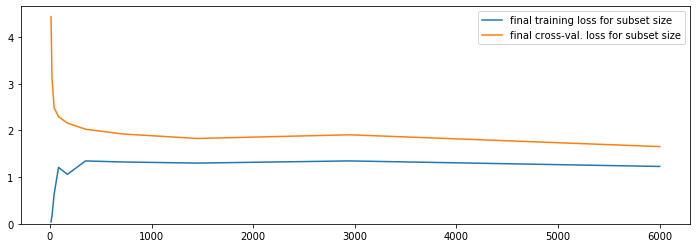

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(subset_sizes, losses_for_subsets,     label='final training loss for subset size')
plt.plot(subset_sizes, val_losses_for_subsets, label='final cross-val. loss for subset size')
ax.set_ylim([0,None])
ax.legend()
plt.show()

We can see that our perceptron definitely doesn't work well for the data. The model seems to have high variance: at a certain point (ca. after learning on 200-500 examples) increasing the size of the training set fails to improve its capability to generalize on unseen data. This is visible from a large gap between training loss and cross-validation loss that stops narrowing down despite the training set being larger and larger.

### 4. Using a convolutional neural network (CNN).

The biggest reason for the perceptron to fail on our data is due to loss of spatial information: it sees only the unrolled data, with two pixels on far-away parts of the image being completely equivalent despite likely belonging to very different features. 

One of the approaches to fix this is by using a convolutional neural network. 

In [55]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

def prep_for_conv(A):
    return A.reshape(A.shape[0],3,32,32)

def make_CNN_model():
    model = Sequential()
    # First layer: 3x32x32 inputs fed into a 2D convolutional layer:
    # * with 20 filters, kernel size of 5x5 (x3 channels), stride of 1 across the image in both X and y directions
    # * using zero-padding of the sides of the image so that the output is __same__ size as input
    # * with linear rectifier activation: vanilla matrix convolution, after which we set any negative outputs to zero
    # * using bias for filter activations
    # * using regular "recommended" way to initialize weights and biases
    # * using no regularization for learning weights and bias 
    # * using no regularization of outputs
    # * using no constraints on kernel or bias
    # The output will be 20x32x32 - 20 filters, 32x32 map of activations of each one
    model.add(Conv2D(50, 5, strides=(1, 1), 
                     input_shape=(3, 32, 32),
                     padding='same', data_format="channels_first",
                     activation='relu', 
                     use_bias=True,
                     kernel_initializer='glorot_uniform', bias_initializer='zeros',
                     kernel_regularizer=None, bias_regularizer=None,
                     activity_regularizer=None,
                     kernel_constraint=None, bias_constraint=None
                    )
             )
    
    # Second layer: max-pool the outputs of the first layer
    # The output will be 20x16x16 - 20 filters, 16x16 map of biggest activations of each one
    # To prevent overfitting, we randomly drop out 25% of the nodes (their output becomes 0)
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_first"))
    model.add(Dropout(0.25))
    
    # Third layer: also a convolution layer but with more filters: we expect more higher-order features
    # The output will be 40x16x16 - 40 filters, 16x16 map of activations of each one
    model.add(Conv2D(100, 3, strides=(1, 1), 
                     padding='same', data_format="channels_first",
                     activation='relu', 
                     use_bias=True,
                     kernel_initializer='glorot_uniform', bias_initializer='zeros',
                     kernel_regularizer=None, bias_regularizer=None,
                     activity_regularizer=None,
                     kernel_constraint=None, bias_constraint=None
                    )
             )    

    # Fourth layer: max-pool the outputs of the third layer
    # The output will be 40x8x8 - 40 filters, 8x8 map of biggest activations of each one
    # To prevent overfitting, we randomly drop out 25% of the nodes (their output becomes 0)
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format="channels_first"))    
    model.add(Dropout(0.25))
    
    
    
    # We now have a 40x8x8 output map. Unroll it into 2560 outputs to feed to the regular NN layer (like in perceptrons)
    model.add(Flatten())
    
    # Fifth layer: regular NN layer (like in perceptrons)
    # To prevent overfitting, we randomly drop out 25% of the nodes (their output becomes 0)
    model.add(Dense(units=512, activation='relu', input_dim=N_DIMENSIONS))
    model.add(Dropout(0.25))
    
    # Sixth and final layer: output regular NN layer with the same number of outputs as categories
    # Use softmax output so that all categories have value from 0 to 1 and neatly sum up to 1
    # Output corresponds to "probabilities" in each category
    model.add(Dense(units=10, activation='softmax', input_dim=N_DIMENSIONS))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model



In [56]:
model = make_CNN_model()

We have our model. Transform the data into a format that can be fed to it, and start training.

In [60]:
from keras.callbacks import ModelCheckpoint

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.accurs = []
        self.val_accurs = []
        self.losses = []
        self.val_losses = []
    # def on_batch_end(self, batch, logs={}):
        # self.accurs.append(logs.get('acc'))
        # self.losses.append(logs.get('loss'))
    def on_epoch_end(self, epoch, logs={}):
        self.val_accurs.append(logs.get('val_acc'))
        self.val_losses.append(logs.get('val_loss'))        
        self.accurs.append(logs.get('acc'))
        self.losses.append(logs.get('loss'))        

history = LossHistory()        
X_train_conv = prep_for_conv(X_train)
X_cv_conv = prep_for_conv(X_cv)

checkpoint_filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [history,checkpoint]

In [61]:
h = model.fit(X_train_conv, Y_train, epochs=10, batch_size=64, callbacks=callbacks_list, validation_data=(X_cv_conv,Y_cv))

Train on 12000 samples, validate on 4000 samples
Epoch 1/10
12000/12000 [==============================] - 134s 11ms/step - loss: 1.8034 - acc: 0.3744 - val_loss: 1.6033 - val_acc: 0.4210

Epoch 00001: val_acc improved from -inf to 0.42100, saving model to weights-improvement-01-0.42.hdf5
Epoch 2/10
12000/12000 [==============================] - 135s 11ms/step - loss: 1.3638 - acc: 0.5230 - val_loss: 1.3546 - val_acc: 0.5048

Epoch 00002: val_acc improved from 0.42100 to 0.50475, saving model to weights-improvement-02-0.50.hdf5
Epoch 3/10
12000/12000 [==============================] - 138s 11ms/step - loss: 1.1691 - acc: 0.5882 - val_loss: 1.1967 - val_acc: 0.5817

Epoch 00003: val_acc improved from 0.50475 to 0.58175, saving model to weights-improvement-03-0.58.hdf5
Epoch 4/10
12000/12000 [==============================] - 129s 11ms/step - loss: 1.0038 - acc: 0.6482 - val_loss: 1.1536 - val_acc: 0.6052

Epoch 00004: val_acc improved from 0.58175 to 0.60525, saving model to weights-imp

Evaluate the model on the test set.

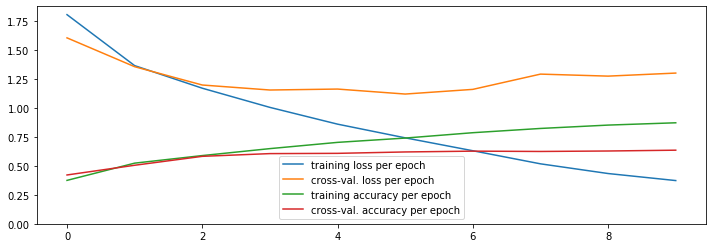

4000/4000 [==============================] - 14s 4ms/step
Loss on test set: ~1.25
Accuracy on test set: ~64%


In [62]:
accurs = history.accurs
val_accurs = history.val_accurs
losses = history.losses 
val_losses = history.val_losses 
epoch_numbers = list(range(0,history.params['epochs']))

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(epoch_numbers, losses, label='training loss per epoch')
plt.plot(epoch_numbers, val_losses, label='cross-val. loss per epoch')
plt.plot(epoch_numbers, accurs, label='training accuracy per epoch')
plt.plot(epoch_numbers, val_accurs, label='cross-val. accuracy per epoch')
ax.set_ylim([0,None])
ax.legend()
plt.show()

X_test_conv = prep_for_conv(X_test)
loss_and_metrics = model.evaluate(X_test_conv, Y_test, batch_size=128)
print('Loss on test set: ~'+'{0:.2f}'.format(loss_and_metrics[0]))
print('Accuracy on test set: ~'+'{0:.0f}'.format(loss_and_metrics[1]*100)+'%')

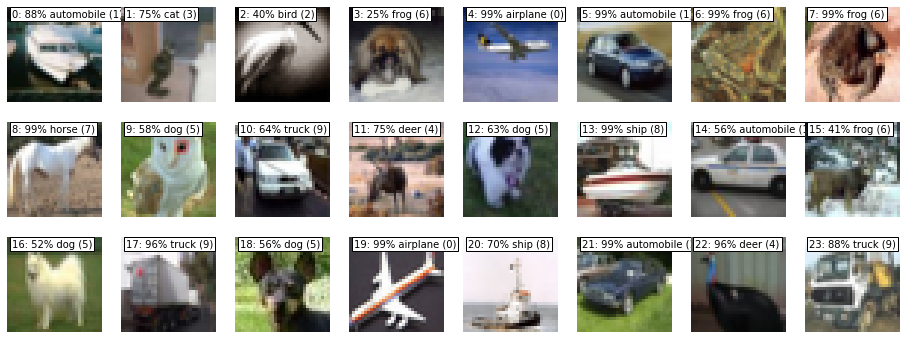

In [64]:
N_ex_show = 100
Y_predicted = model.predict(X_test_conv[:N_ex_show], batch_size=128)

Y_predicted_probability = np.max(Y_predicted[:N_ex_show], axis=1)
Y_predicted_category = np.argmax(Y_predicted[:N_ex_show], axis=1)

X_show = scaler.inverse_transform(X_test[:N_ex_show]).astype(int)
show_examples_of_data(X_show, Y_predicted_category, show_probabilities=True, probabilities=Y_predicted_probability)